# Assignment 2

### Author : Adarsh T. Shah, IISc, MTech(AI)

In [2]:
import numpy as np
from skimage import io,color,img_as_float32,img_as_ubyte
from matplotlib import pyplot as plt
from math import e,sqrt,radians,cos,sin
from scipy.signal import convolve2d
from scipy.optimize import minimize
import cv2
import random

# 1. Contrast Enhancement

### 1.1 Full Scale Contrast Enhancement

In [53]:
def FSCS(image:np.ndarray)->np.ndarray:
    image = img_as_float32(image)
    mn = np.min(image)
    mx = np.max(image)
    image = np.divide(np.subtract(image,mn),mx-mn)
    image = img_as_ubyte(image)
    return image

### 1.2 Non Linear Contrast Stretching

In [144]:
def NLCS(image:np.ndarray)->np.ndarray:
    image = img_as_float32(image)
    image = np.log2(np.add(1,image))
    image = img_as_ubyte(image)
    image = FSCS(image)
    return image

### 1.3 Histogram Equalization

In [19]:
def HE(image:np.ndarray)->np.ndarray:
    x,P = histogram(image,bins=256)
    sum = np.sum(P)
    for i in range(256):
        P[i]=P[i]/sum
    for i in range(1,256):
        P[i]+=P[i-1]
    func = lambda x : P[x]*255
    func = np.vectorize(func)
    image = np.round(func(image)).astype(int)
    image = FSCS(image)
    return image

### 1.4 CLAHE

In [146]:
def CLAHE(image:np.ndarray,clip_limit:int=400)->np.ndarray:
    l,b = np.shape(image)
    l,b = l//8,b//8
    resimage = np.ones(shape=np.shape(image))
    for i in range(0,8):
        for j in range(0,8):
            img = image[i*l:(i+1)*l,j*b:(j+1)*b]
            _,P = histogram(img,bins=256)
            P = P.astype(int)
            clipped = 0
            for h in range(256):
                if P[h] > clip_limit:
                    clipped = clipped + P[h] - clip_limit
                    P[h] = clip_limit
            P = np.round(np.add(P,clipped/255))
            sum = np.sum(P)
            for k in range(256):
                P[k]=P[k]/sum
            for k in range(1,256):
                P[k]+=P[k-1]
            P = np.round(np.multiply(P,255))
            func = lambda x : P[x]
            func = np.vectorize(func)
            resimage[i*l:i*l+l,j*b:(j+1)*b] = func(img).astype(int)
    return resimage.astype(int)

### 1.5 CLAHE with 1.25%boundaries

In [147]:
def CLAHE1(image:np.ndarray,clip_limit:np.ndarray=400)->np.ndarray:
    l,b = np.shape(image)
    l,b = l//8,b//8
    resimage = np.ones(shape=np.shape(image))
    for i in range(0,8):
        for j in range(0,8):
            br,ur,bc,uc = i*l,i*l+l,j*b,j*b+b
            if i>0:
                br-=0.25*l
            if i<7:
                ur+=0.25*l
            if j>0:
                bc-=0.25*b
            if j<7:
                uc+=0.25*b
            br,ur,bc,uc = int(br),int(ur),int(bc),int(uc)
            img = image[br:ur,bc:uc]
            _,P = histogram(img,bins=256)
            P = P.astype(int)
            clipped = 0
            for h in range(256):
                if P[h] > clip_limit:
                    clipped = clipped + P[h] - clip_limit
                    P[h] = clip_limit
            P = np.round(np.add(P,clipped/255))
            sum = np.sum(P)
            for k in range(256):
                P[k]=P[k]/sum
            for k in range(1,256):
                P[k]+=P[k-1]
            P = np.round(np.multiply(P,255))
            func = lambda x : P[x]
            func = np.vectorize(func)
            resimage[i*l:i*l+l,j*b:(j+1)*b] = func(image[i*l:i*l+l,j*b:(j+1)*b]).astype(int)
    return resimage.astype(int)

In [148]:
def contrastEnhance(image:np.ndarray,method:str='FSCS',clip_limit:int=400):
    if method == 'FSCS':
        return FSCS(image)
    elif method == 'NLCS':
        return NLCS(image)
    elif method == 'HE':
        return HE(image)
    elif method == 'CLAHE':
        return CLAHE(image,clip_limit=clip_limit)
    elif method == 'CLAHE1':
        return CLAHE1(image,clip_limit=clip_limit)

### Testing Contrast Enhancement

In [149]:
def testContrastEnhancement(method:str):
    files = ['inputs/IIScMainBuilding_LowContrast.png','inputs/LowLight_2.png','inputs/LowLight_3.png','inputs/Hazy.png','inputs/StoneFace.png']
    for file in files:
        image = io.imread(file)
        plt.subplot(221)
        plt.imshow(image,cmap=plt.cm.gray)
        x,y=histogram(image,bins=256)
        plt.subplot(222)
        plt.bar(x,y)
        resimg = contrastEnhance(image,method,clip_limit=1000)
        plt.subplot(223)
        plt.imshow(resimg,cmap=plt.cm.gray)
        x,y=histogram(resimg,bins=256)
        plt.subplot(224)
        plt.bar(x,y)
        plt.show()
    

# 2. Image Upsampling

In [3]:
def subsample(image:np.ndarray,k:int=2)->np.ndarray:
    L,B = image.shape
    newimg = np.zeros(shape=(L//k,B//k))
    for l in range(L//k):
        for b in range(B//k):
            newimg[l][b]=image[k*l][k*b]
    return newimg.astype(int)

def upsample(image:np.ndarray,method:str,k:int)->np.ndarray:
    if method=='NNI':
        return NNI(image,k)
    if method=='bilinear':
        return Bilinear(image,k)

### 2.1 Nearest Neighbour Interpolation

In [4]:
def NNI(image:np.ndarray,k:int)->np.ndarray:
    L,B = image.shape
    resimage = np.zeros(shape=(L*k,B*k))
    for l in range(k*L):
        for b in range(k*B):
            resimage[l,b]=image[l//k][b//k]
    return resimage.astype(int)

### 2.2 Bilinear Interpolation

In [5]:
def Bilinear(image:np.ndarray,k:int)->np.ndarray:
    image = NNI(image,k)
    resimage = image.copy()
    L,B = image.shape
    for l in range(1,L-1):
        for b in range(1,B-1):
            A = np.array([[1,l-1,b-1,(l-1)*(b-1)],
                         [1,l+1,b-1,(l+1)*(b-1)],
                         [1,l-1,b+1,(l-1)*(b+1)],
                         [1,l+1,b+1,(l+1)*(b+1)]])
            I = np.array([[image[l-1,b-1]],[image[l+1,b-1]],[image[l-1,b+1]],[image[l+1,b+1]]])
            d = np.linalg.inv(A).dot(I)
            resimage[l,b]=d[0,0]+l*d[1][0]+b*d[2][0]+l*b*d[3][0]
    return np.round(resimage).astype(int)

### Testing Image Upsampling

In [6]:
def testImageUpsampling(method='NNI',k=2):
    files = ['inputs/StoneFace.png','inputs/Bee.jpg']
    for file in files:
        image = io.imread(file)
        try:
            L,B = image.shape
        except ValueError:
            image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            L,B = image.shape
        image = image[:k*(L//k),:k*(B//k)]
        resimage = subsample(image,k)
        plt.subplot(121)
        plt.imshow(resimage,cmap=plt.cm.gray)
        plt.subplot(122)
        resimage1 = upsample(resimage,method,k)
        error = sqrt(np.sum(np.square(np.subtract(image,resimage1))))/(L*B)
        plt.imshow(resimage1,cmap=plt.cm.gray)
        plt.show()
        print(f'Error : {error:.5}')

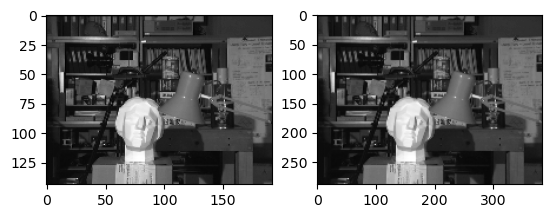

Error : 0.044034


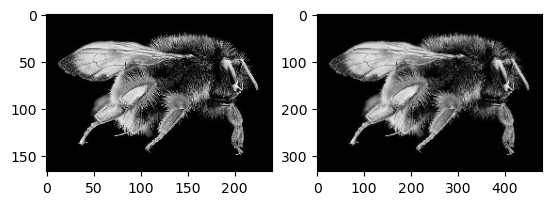

Error : 0.055771


In [7]:
testImageUpsampling()

### 3. Image Rotation

In [8]:
def rotate(image:np.ndarray,d:float,inter:str='NNI')->np.ndarray:
    d_=radians(d)
    d = 180-d
    M = np.max(image.shape)
    X = lambda a,b : int(-1*a*cos(radians(d))+b*sin(radians(d)))
    Y = lambda a,b : int(-1*a*sin(radians(d))-b*cos(radians(d)))
    res = np.zeros(shape=(M+M//2,M+M//2))
    res1 = np.zeros(shape=(M+M//2,M+M//2))
    a,b = X(0,0),Y(0,0)
    L,B = image.shape
    for i in range(L):
        for j in range(B):
            res[X(i,j),Y(i,j)] = image[i,j]
            a=min(a,X(i,j))
            b=min(b,Y(i,j))
    for i in range(M+M//2):
        for j in range(M+M//2):
            res1[i,j]=res[i+a,j+b]
    L,B = image.shape
    res1=res1[:int(abs(L*cos(d_))+abs(B*sin(d_))),:int(abs(L*sin(d_))+abs(B*cos(d_)))]
    L,B = res1.shape
    if inter == 'NNI':
        res1=upsample(res1,method='NNI',k=2)
    elif inter == 'bilinear':
        res1=upsample(res1,method='bilinear',k=1)
    return res1.astype(int)

### 4. Spatial Filter 

In [10]:
def smooth(image:np.ndarray,m:int)->np.ndarray:
    h = np.ones(shape=(m,m))
    image = img_as_float32(image)
    res = convolve2d(image,h,mode='same')/(m**2)
    return img_as_ubyte(res)

def highBoostFiltering(image:np.ndarray,m:int,k:float)->np.ndarray:
    gmask = image-smooth(image,m)
    image,gmask = img_as_float32(image),img_as_float32(smooth)
    res = image + k*gmask
    mx1,mn1,mx,mn = np.max(image),np.min(image),np.max(res),np.min(res)
    res = (res-mn)/(mx-mn)*(mx1-mn1)
    return img_as_ubyte(res),smooth(image,m)

### 4.2 Test

In [13]:
def testHighBoostFiltering(m):
    img = io.imread('inputs/noisy.tif')
    #Minimizing Scaling Constant
    obj = lambda k : sqrt(np.sum(np.square(highBoostFiltering(img,m,k)[0]-img)))/(img.shape[0]*img.shape[1])
    fmin = minimize(fun=obj,x0=[1])
    k = fmin.x[0]
    print(f'm = {m} Optimized k={k:.6f}')
    res1,res2 = highBoostFiltering(img,m,1)
    plt.imshow(res1,cmap=plt.cm.gray)
    plt.show()

testHighBoostFiltering(5)
testHighBoostFiltering(10)
testHighBoostFiltering(15)

ValueError: Can not convert from object to float32.